In [1]:
pip install faker

     |████████████████████████████████| 1.1 MB 1.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import re, random

from faker import Faker
from babel.dates import format_date

pd.options.display.max_colwidth = None
sns.set_style('darkgrid')

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers, losses, callbacks, utils

# Data Generation

In [4]:
class config():  
    SAMPLE_SIZE = 1_000_000
    
    MAX_LEN = 30
    LATENT_DIM = 8
    Y_LEN = 10
    NUM_DECODER_TOKENS = 12
    
    VALIDATION_SIZE = 0.1
    BATCH_SIZE = 8
    MAX_EPOCHS = 25
        
    DATE_FORMATS = [
        'short', 'medium', 'long', 'full',
        'd MMM YYY', 'd MMMM YYY', 'dd/MM/YYY',
        'EE d, MMM YYY', 'EEEE d, MMMM YYY', 'd of MMMM YYY',
    ]

In [5]:
faker = Faker()
print('Sample dates for each format\n')

for fmt in set(config.DATE_FORMATS):
    print(f'{fmt:20} =>  {format_date(faker.date_object(), format=fmt, locale="en")}')

Sample dates for each format

EEEE d, MMMM YYY     =>  Sunday 28, October 2018
d of MMMM YYY        =>  12 of September 1979
d MMM YYY            =>  26 Jul 1989
EE d, MMM YYY        =>  Fri 23, Aug 1985
dd/MM/YYY            =>  10/10/2011
full                 =>  Friday, December 28, 2012
medium               =>  Jan 20, 2003
d MMMM YYY           =>  25 June 1987
long                 =>  October 5, 1981
short                =>  5/7/77


In [6]:
def clean_date(raw_date):
    return raw_date.lower().replace(',', '')


def create_dataset(num_rows):
    dataset = []
    
    for i in tqdm(range(num_rows)):
        dt = faker.date_object()
        for fmt in config.DATE_FORMATS:
            try:
                date = format_date(dt, format=fmt, locale='en')
                human_readable = clean_date(date)
                machine_readable = dt.isoformat()
            except AttributeError as e:
                date = None
                human_readable = None
                machine_readable = None
            if human_readable is not None and machine_readable is not None:
                dataset.append((human_readable, machine_readable))
 
    return pd.DataFrame(dataset, columns=['human_readable', 'machine_readable'])

In [7]:
dataset = create_dataset(config.SAMPLE_SIZE)
dataset  = dataset.drop_duplicates(subset=['human_readable']).sample(frac=1.0).reset_index(drop=True)
print(dataset.shape)
dataset.head()


(182766, 2)


,human_readable,machine_readable
0,5/18/90,1990-05-18
1,june 23 1983,1983-06-23
2,saturday 19 september 1970,1970-09-19
3,23 of january 1981,1981-01-23
4,24 of september 2007,2007-09-24


In [8]:
human_tokenizer = Tokenizer(char_level=True, oov_token='<oov>')
machine_tokenizer = Tokenizer(char_level=True)

human_tokenizer.fit_on_texts(dataset['human_readable'].values)
machine_tokenizer.fit_on_texts(dataset['machine_readable'].values)

print(human_tokenizer.word_index)

{'<oov>': 1, ' ': 2, '1': 3, '2': 4, '9': 5, '0': 6, 'a': 7, 'e': 8, 'r': 9, 'u': 10, '8': 11, '7': 12, '/': 13, 'y': 14, 'o': 15, 'n': 16, 'd': 17, 'm': 18, 't': 19, 's': 20, '3': 21, 'b': 22, '5': 23, '4': 24, '6': 25, 'f': 26, 'j': 27, 'c': 28, 'p': 29, 'l': 30, 'h': 31, 'i': 32, 'g': 33, 'v': 34, 'w': 35}


In [9]:
def preprocess_input(date, tokenizer, max_len):
    seq = [i[0] for i in tokenizer.texts_to_sequences(date.lower().replace(',', ''))]
    seq = pad_sequences([seq], padding='post', maxlen=max_len)[0]
    return utils.to_categorical(seq, num_classes=len(tokenizer.word_index)+1)

In [10]:
%%time

X = np.array(list(map(lambda x: preprocess_input(x, human_tokenizer, config.MAX_LEN), dataset['human_readable'])))
y = np.array(list(map(lambda x: preprocess_input(x, machine_tokenizer, 10), dataset['machine_readable'])))

X.shape, y.shape

CPU times: user 24.2 s, sys: 582 ms, total: 24.8 s
Wall time: 25 s


((182766, 30, 36), (182766, 10, 12))

# Modelling

In [11]:
class NMTAutoencoder(Model):
    def __init__(self):
        super(NMTAutoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Bidirectional(layers.LSTM(config.LATENT_DIM))
        ])

        self.decoder = tf.keras.Sequential([
            layers.RepeatVector(config.Y_LEN),
            layers.Bidirectional(layers.LSTM(config.LATENT_DIM, return_sequences=True)),
            layers.TimeDistributed(layers.Dense(config.NUM_DECODER_TOKENS, activation='softmax')),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = NMTAutoencoder()
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [12]:
history = model.fit(
    X, y, epochs=config.MAX_EPOCHS, batch_size=config.BATCH_SIZE, 
    validation_split=config.VALIDATION_SIZE
)

Epoch 1/25
20562/20562 [==============================] - 213s 10ms/step - loss: 0.7746 - val_loss: 0.4189
Epoch 2/25
20562/20562 [==============================] - 212s 10ms/step - loss: 0.2117 - val_loss: 0.0922
Epoch 3/25
20562/20562 [==============================] - 211s 10ms/step - loss: 0.0500 - val_loss: 0.0212
Epoch 4/25
20562/20562 [==============================] - 202s 10ms/step - loss: 0.0146 - val_loss: 0.0082
Epoch 5/25
20562/20562 [==============================] - 201s 10ms/step - loss: 0.0077 - val_loss: 0.0061
Epoch 6/25
20562/20562 [==============================] - 200s 10ms/step - loss: 0.0056 - val_loss: 0.0045
Epoch 7/25
20562/20562 [==============================] - 206s 10ms/step - loss: 0.0046 - val_loss: 0.0037
Epoch 8/25
20562/20562 [==============================] - 197s 10ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 9/25
20562/20562 [==============================] - 195s 9ms/step - loss: 0.0038 - val_loss: 0.0031
Epoch 10/25
20562/20562 [=============

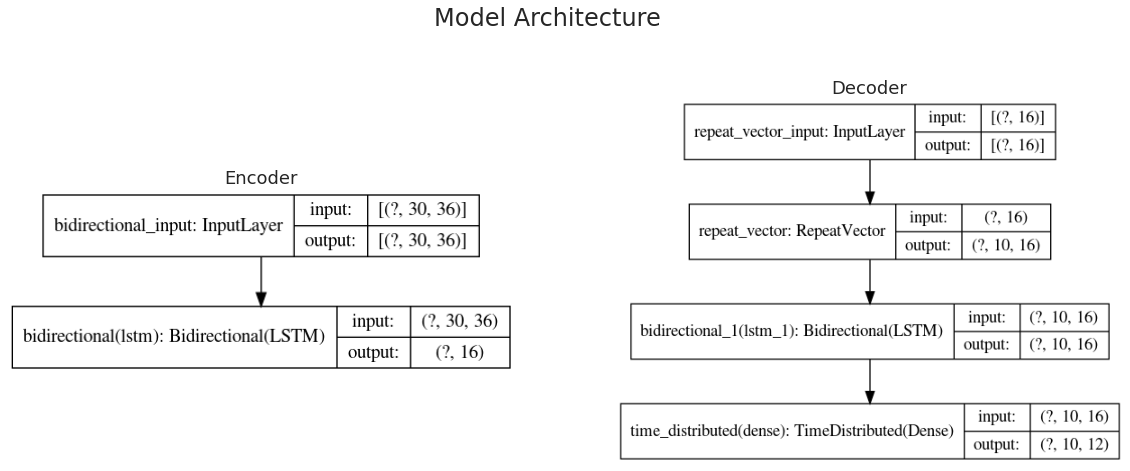

In [13]:
utils.plot_model(model.encoder, show_shapes=True, expand_nested=True, to_file='encoder.png')
utils.plot_model(model.decoder, show_shapes=True, expand_nested=True, to_file='decoder.png')
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].imshow(plt.imread('encoder.png')); ax[0].axis('off'); ax[0].set_title('Encoder', fontsize=18)
ax[1].imshow(plt.imread('decoder.png')); ax[1].axis('off'); ax[1].set_title('Decoder', fontsize=18)
fig.suptitle('Model Architecture', fontsize=24);

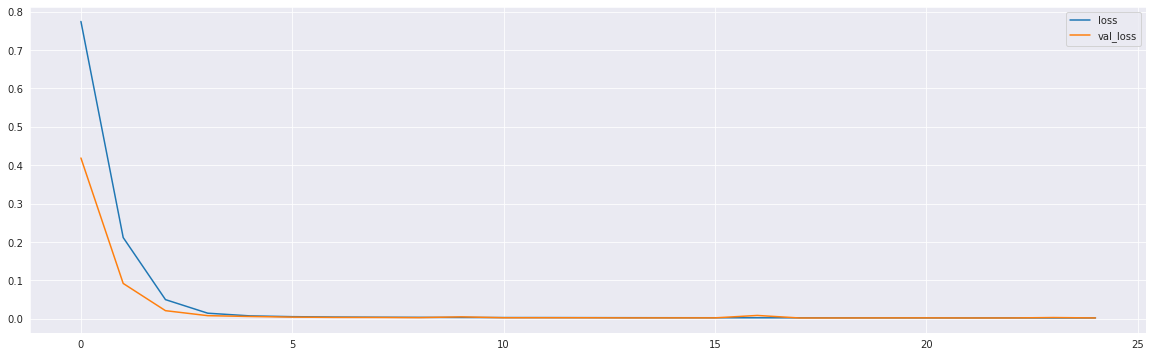

In [14]:
fig, ax = plt.subplots(figsize=(20, 6))
pd.DataFrame(history.history).plot(ax=ax)
del history

In [15]:
model.encoder.save('nmt_encoder.h5')
model.decoder.save('nmt_decoder.h5')

# Evaluation

In [16]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_sequence(model, tokenizer, source):
    prediction = model.predict(source, verbose=0)[0]
    integers = [np.argmax(vector) for vector in prediction]
    target = list()
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ''.join(target)

def decode_sequence(tokenizer, source):
    integers = [np.argmax(vector) for vector in source]
    target = list()
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ''.join(target)

In [17]:
query_idx = 101

print('SOURCE     :', decode_sequence(human_tokenizer, np.squeeze(X[query_idx:query_idx+1])))
print('TARGET     :', decode_sequence(machine_tokenizer, np.squeeze(y[query_idx:query_idx+1])))
print('PREDICTION :', predict_sequence(model, machine_tokenizer, X[query_idx:query_idx+1]))

SOURCE     : 9 of april 2006
TARGET     : 2006-04-09
PREDICTION : 2006-04-09


In [18]:
query_text = 'saturday 19 september 1998'
query = np.array(list(map(lambda x: preprocess_input(x, human_tokenizer, config.MAX_LEN), [query_text])))

print('SOURCE     :', query_text)
print('PREDICTION :', predict_sequence(model, machine_tokenizer, query))

SOURCE     : saturday 19 september 1998
PREDICTION : 1998-09-19
